In [1]:
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
from skimage.measure import block_reduce # pip install scikit-image
import mpl_scatter_density
import glob, os, time
from torch.utils.data import Dataset, ConcatDataset, DataLoader, sampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import roc_curve, auc
from utils import *
import warnings
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(0)

Welcome to JupyROOT 6.24/02


In [2]:
figOutDir = './PLOTS/2_Training_Validation/'

os.system('mkdir -p {}'.format(figOutDir))

0

### Get Data

In [3]:
# Import data

files = glob.glob('../DATA/500ev_EE_ECALDQM_*.parquet')
print('Total number of parquet files: {}'.format(len(files)))
#f = [pq.ParquetFile(i) for i in files]

print('\nError reading the file below: ')
f = []
for i in range(len(files)):
    try:
        f.append(pq.ParquetFile(files[i]))
    except:
        print(files[i])
        files[i] = None
files.remove(None)

nEntries = [i.num_row_groups for i in f] 

Total number of parquet files: 240

Error reading the file below: 
../DATA/500ev_EE_ECALDQM_run316766.parquet


In [4]:
class ParquetDataset(Dataset):
    def __init__(self, file):
        self.parquet = pq.ParquetFile(file)
        self.cols = ['PU', 'lumi', 'EEOccupancyTask_EEOT_digi_occupancy_EE_m.list.item.list.item', 'EEOccupancyTask_EEOT_digi_occupancy_EE_p.list.item.list.item']
    def __getitem__(self, index):
        data = dict([])
        for key in self.cols:
            key = key.split('.')[0]
            try:
                data[key] = np.float64(self.parquet.read_row_groups(index, columns=[key]).to_pydict()[key])
            except:
                data[key] = np.float64(self.parquet.read_row_group(index, columns=[key]).to_pydict()[key])
        return data
    def __len__(self):
        return self.parquet.num_row_groups

In [5]:
datasetAll = ConcatDataset([ParquetDataset(f) for f in files])

In [6]:
# Split into training and validation set
n_train = int(0.7*len(datasetAll))
n_val = len(datasetAll) - n_train
idxs = np.random.permutation(len(datasetAll))
#idxs = range(len(dataset))
idxs_train, idxs_val = idxs[:n_train], idxs[-n_val:]

batch_size = 32

# For training: use 70% of the dataset, shuffle at every epoch, batch size of 32
train_sampler = sampler.SubsetRandomSampler(idxs_train)
train_loader = DataLoader(dataset=datasetAll, batch_size=32, num_workers=10, sampler=train_sampler, pin_memory=True, drop_last=True)

# For validation: use 30% of the dataset, no shuffle so to compare the same image from epoch to epoch, batch size of 32
val_sampler = sampler.SequentialSampler(idxs_val)
val_loader = DataLoader(dataset=datasetAll, batch_size=batch_size, num_workers=10, sampler=val_sampler, pin_memory=True, drop_last=True)

# For iterating over the entire dataset before any ML stuff; no shuffle; no batch;
file_sampler = sampler.SequentialSampler(range(len(datasetAll)))
file_loader = DataLoader(dataset=datasetAll, sampler=file_sampler)

In [7]:
# GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Functions: Plot Images, Apply PU Correction, Apply Fake Anomalies, Add Padding around the Images

In [8]:
# 2D img plot
def plot_2D(img, title = '', doColorbar=True, doLog=False, label='', xlabel='ix', ylabel='iy', vmax=0, doTick=True, doSave=False, figName='plot'):
    fig, ax = plt.subplots()

    cmap = plt.cm.get_cmap('jet')
    cmap.set_bad(color='black')
    cmap.set_under(color='white')
    
    ax.imshow(np.zeros_like(img), origin='lower', cmap=cmap)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if doLog:
        im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap, vmax=vmax)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', cmap=cmap, vmax=vmax)

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.015, label=label)
        
    off = 0.5
    
    if doTick:
        ax.set_xticks(np.arange(0,22,2)-off)
        ax.set_yticks(np.arange(0,22,2)-off)

        ax.set_xticklabels(np.arange(0,22,2))
        ax.set_yticklabels(np.arange(0,22,2))
    
    # HORIZONTAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = 0, 20
        y1, y2 = i, i
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')
    # VERTICAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = i, i
        y1, y2 = 0, 20
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')

    
    # labels
    plt.xlabel(xlabel, size=11)
    plt.ylabel(ylabel, size=11)
    plt.title(title, fontsize=13)
    
    if doSave:
        plt.savefig('{}.png'.format(figName))
    
    plt.show()

In [9]:
# Linear regression on Total Occupancy vs. PU
PUdir = './PU_Correction/'
fit = {'p': np.loadtxt('{}EEp_PU_Correction_Factor.csv'.format(PUdir), delimiter=','), 'm': np.loadtxt('{}EEm_PU_Correction_Factor.csv'.format(PUdir), delimiter=',')} # fit parameters for EE+(p) and EE-(m)

# Apply PU correction to occupancy maps for all LS
# Then multiply by # of towers (20x20) to make the mean occupancy across the pixels 1.

def applyPUcorr(img, PU, fit):
    scale = fit[0]*PU+fit[1]

    # reshape the `scale` tensor if necessary to perform division with `img` tensor, to match the dimensions
    # -> if the img tensor has the size of e.g. [batch_size, 1, 20, 20] whereas PU has the size [batch_size, 1],
    # -> you need to reshape the PU tensor as [batch_size, 1, 1, 1] by adding the extra 2 dimensions
    # -> but if img and PU tensor have the same shape, you don't add any extra dimensions
    scaleShape = list(scale.shape)
    extraDim = [1]*(len(img.shape)-len(PU.shape)) # additional dimensions
    scaleShape += extraDim
    
    scale = scale.reshape(torch.Size(scaleShape))
    
    corrected = img / scale

    return 20*20*corrected

In [10]:
def generateFakeAnomCoord(validIndex, nCoord):
    np.random.seed(0)
    fakeIndex = np.random.randint(0, len(validIndex), size=nCoord) # nCoord == batch_size * (# of batches)
    fakeCoord = [validIndex[i] for i in fakeIndex]
    
    return fakeCoord

def applyFakeAnomaly(img, fakeIndex, anomValue=0):
    if len(fakeIndex) == 2:
        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)
        
        img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]] = anomValue
    # img has the shape of (N of images, N of layers, rows, cols)
    else:
        fakeIndex = torch.tensor(fakeIndex)
        fakeRows = fakeIndex[:,0]  # extract list of rows
        fakeCols = fakeIndex[:,1]  # extract list of cols

        
        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeRows, fakeCols]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)

        img[range(img.shape[0]), :, fakeRows, fakeCols] = anomValue
        
    return img

In [11]:
def addPadding(img):
    if len(img.shape) == 2:
        pad_top = torch.unsqueeze(img[img.shape[1]-1,:],0)
        img = torch.cat((img, pad_top), 0)
        #plot_2D(img)

        pad_bottom = torch.unsqueeze(img[0,:],0)
        img = torch.cat((pad_bottom, img), 0)
        #plot_2D(img)

        pad_left = torch.unsqueeze(img[:,0], 1)
        img = torch.cat((pad_left, img), 1)
        #plot_2D(img)

        pad_right = torch.unsqueeze(img[:,img.shape[1]-1], 1)
        img = torch.cat((img, pad_right), 1)
        #plot_2D(img.detach().cpu())
        
    elif len(img.shape) == 4:
        pad_top = torch.unsqueeze(img[:,:,img.shape[2]-1,:],2)
        img = torch.cat((img, pad_top), 2)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_bottom = torch.unsqueeze(img[:,:,0,:],2)
        img = torch.cat((pad_bottom, img), 2)
        #plot_2D(img[10][0].detach().cpu())
           
        pad_left = torch.unsqueeze(img[:,:,:,0], 3)
        img = torch.cat((pad_left, img), 3)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_right = torch.unsqueeze(img[:,:,:,img.shape[3]-1], 3)
        img = torch.cat((img, pad_right), 3)
        #plot_2D(img[10][0].detach().cpu())
        
    return img

### Average Occupancy Map

In [14]:
avg_occ_dir = './Avg_Occupancy/'
avg_occupancy = {'p': np.loadtxt('{}avg_occupancy_EEp.csv'.format(avg_occ_dir), delimiter=','), 'm': np.loadtxt('{}avg_occupancy_EEm.csv'.format(avg_occ_dir), delimiter=',')}

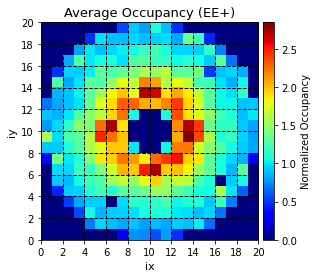

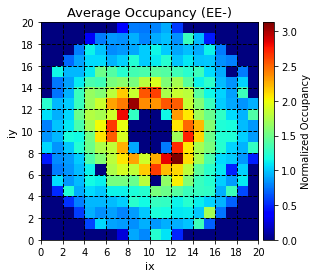

In [15]:
plot_2D(avg_occupancy['p'], title='Average Occupancy (EE+)', label='Normalized Occupancy')
plot_2D(avg_occupancy['m'], title='Average Occupancy (EE-)', label='Normalized Occupancy')

### Get Valid Towers

In [16]:
valid_tower_dir = './Valid_Tower_List/'
validIndex = {'p': list(np.loadtxt('{}valid_towers_EEp.csv'.format(valid_tower_dir), delimiter=',').astype(int)), 'm': list(np.loadtxt('{}valid_towers_EEm.csv'.format(valid_tower_dir), delimiter=',').astype(int))}

validIndex['p'] = [ idx.tolist() for idx in validIndex['p']]
validIndex['m'] = [ idx.tolist() for idx in validIndex['m']]

In [17]:
print('Number of valid indices')
print('EE+: {}, EE-: {}'.format(len(validIndex['p']), len(validIndex['m'])))

Number of valid indices
EE+: 306, EE-: 309


### ML: Model Class

In [18]:
doPadding = True

In [19]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.LeakyReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

In [20]:
if doPadding:
    layer0_kernel = 3
    layer2_shape = 10
    final_shape = 22
else:
    layer0_kernel = 5
    layer2_shape = 8
    final_shape = 20

class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=layer0_kernel, stride=1, padding=(0,0)), nn.LeakyReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*int(layer2_shape/2)*int(layer2_shape/2))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(layer2_shape, layer2_shape))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=layer0_kernel, stride=1, padding=(0,0))
        self.dconv0_relu = nn.LeakyReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size(), 'input')
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size(), 'econv0')
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size(), 'maxpool')

        x = self.elayer1(x)
        if self.debug: print(x.size(), 'elayer1')
        x = self.elayer2(x)
        if self.debug: print(x.size(), 'elayer2')
        x = self.elayer3(x)
        if self.debug: print(x.size(), 'elayer3')
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Bottleneck")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size(), 'GlobalMaxPool')
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size(), 'flatten')
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        if self.debug: print("Expand bottleneck")
        x = self.fc(x) # expand
        if self.debug: print(x.size(), 'FC-upsample')
        x = x.view(-1, self.fmaps[1], int(layer2_shape/2), int(layer2_shape/2))
        if self.debug: print(x.size(), 'reshape')
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer3(x)
        if self.debug: print(x.size(), 'dlayer3')
        x = self.dlayer2(x)
        if self.debug: print(x.size(), 'dlayer2')
        x = self.dlayer1(x)
        if self.debug: print(x.size(), 'dlayer1')
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size(), "interp")
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, final_shape, final_shape)) 
        if self.debug: print(x.size(), 'dconv0')
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

### ML Functions: Evalulate during Validation, Calculate FDR

In [ ]:
def do_eval(ae, loader, epoch, doPadding=False, spatialCorr=False, timeCorr=False, isDead=False, isHot=False, fakeIndices=[], avg_occ=[], idx=0):
    loss_ = []
    
    if spatialCorr:
        avg_occ = torch.tensor(avg_occupancy[EE]).to(device)
        avg_occ[avg_occ==0] = 1
        
        if doPadding:
            avg_occ = addPadding(avg_occ)
    
    for i, data in enumerate(loader):
        X, PU = data['EEOccupancyTask_EEOT_digi_occupancy_EE_{}'.format(EE)].to(device), data['PU'].to(device)
        
        # Fake anomaly value
        if isDead:
            anomValue = 0
        elif isHot:
            f = 0.2
            hotValue = 25*500*f
                    
            anomValue = hotValue
            #anomValue[anomValue > 8] = 8.
        
        
        if timeCorr:
            # Apply Fake Anomaly
            if isDead or isHot:
                fakeIndex = fakeIndices[i*batch_size:(i+3)*batch_size] # batch size is 1
                
                X_curr = applyFakeAnomaly(torch.tensor(X), fakeIndex[0], anomValue, relOcc)
                X_next = applyFakeAnomaly(torch.tensor(X), fakeIndex[1], anomValue, relOcc)
                X_next2 = applyFakeAnomaly(torch.tensor(X), fakeIndex[2], anomValue, relOcc)
                #print(i, fakeIndex)
            else:
                X_curr, X_next, X_next2 = X, X, X
            
            # Padding
            if doPadding:
                X_curr = addPadding(X_curr)
                X_next = addPadding(X_next)
                X_next2 = addPadding(X_next2)
            
            # PU Correction
            X_curr = applyPUcorr(X_curr, PU, fit[EE]).float()
            X_next = applyPUcorr(X_next, PU, fit[EE]).float()
            X_next2 = applyPUcorr(X_next2, PU, fit[EE]).float()
            
            #if isDead or isHot:
            #    plot_2D(X_curr[0][0].detach().cpu(), title='{} curr'.format(i))
            #    plot_2D(X_next[0][0].detach().cpu(), title='{} next'.format(i))
            #    plot_2D(X_next2[0][0].detach().cpu(), title='{} next2'.format(i))
            
            # Feed to AE
            Xreco_curr = ae(X_curr)
            Xreco_next = ae(X_next)
            Xreco_next2 = ae(X_next2)
            
            # Spatial Correction
            if spatialCorr:
                losses_curr = F.mse_loss(Xreco_curr.float()/avg_occ.float(), X_curr.float()/avg_occ.float(), reduction='none')
                losses_next = F.mse_loss(Xreco_next.float()/avg_occ.float(), X_next.float()/avg_occ.float(), reduction='none')
                losses_next2 = F.mse_loss(Xreco_next2.float()/avg_occ.float(), X_next2.float()/avg_occ.float(), reduction='none')
                
                #if isDead or isHot:
                #    plot_2D(losses_curr[0][0][1:21,1:21].detach().cpu(), title='{} curr'.format(i))
                #    plot_2D(losses_next[0][0][1:21,1:21].detach().cpu(), title='{} next'.format(i))
                #    plot_2D(losses_next2[0][0][1:21,1:21].detach().cpu(), title='{} next2'.format(i))
                
            else:
                losses_curr = F.mse_loss(Xreco_curr.float(), X_curr.float(), reduction='none')
                losses_next = F.mse_loss(Xreco_next.float(), X_next.float(), reduction='none')
                losses_next2 = F.mse_loss(Xreco_next2.float(), X_next2.float(), reduction='none')
                
            # Time Corrected Loss          
            if i == 0:
                three_losses['first'] = []
                three_losses['second'] = []
                three_losses['third'] = []
                
                three_losses['first'].append(losses_next2)
            elif i == 1:
                three_losses['second'].append(losses_next)
                three_losses['first'].append(losses_next2)
            else:
                three_losses['third'].append(losses_curr)
                
                #if i >= 2 and i < 5:
                #    if isDead or isHot:
                #        plot_2D(three_losses['first'][0][0][0][1:21,1:21].detach().cpu(), title='Loss first')
                #        plot_2D(three_losses['second'][0][0][0][1:21,1:21].detach().cpu(), title='Loss second')
                #        plot_2D(three_losses['third'][0][0][0][1:21,1:21].detach().cpu(), title='Loss current')

                losses = three_losses['first'][0]*three_losses['second'][0]*three_losses['third'][0]
                
                #if i >= 2 and i < 5:
                #    if isDead or isHot:
                #        plot_2D(losses[0][0][1:21,1:21].detach().cpu(), title='New loss')

                for i_loss in three_losses:
                    three_losses[i_loss].pop(0)
                
                three_losses['second'].append(losses_next)
                three_losses['first'].append(losses_next2)
                
            
        # if not time correction  
        else:
            # Apply Fake Anomaly
            if isDead or isHot:
                fakeIndex = fakeIndices[i*batch_size:(i+1)*batch_size] # batch size is not 1
                X = applyFakeAnomaly(X, fakeIndex, anomValue)
            
            # Padding
            if doPadding:
                X = addPadding(X)

            # PU Correction
            X = applyPUcorr(X, PU, fit[EE]).float()
            #X = applyPUcorr(X, PU, fit_run[runEra][EE]).float()
        
            # Feed to AE
            Xreco = ae(X)
        
            # Spatial Correction
            if spatialCorr:
                losses = F.mse_loss(Xreco.float()/avg_occ.float(), X.float()/avg_occ.float(), reduction='none')
            else:
                losses = F.mse_loss(Xreco.float(), X.float(), reduction='none')
        
        # Process loss maps into good and anom losses
        if i >= 2: 
            # Padding
            if doPadding:
                losses = losses[:,:,1:21,1:21]

            # Get losses of anomalous for anomaly validation and of good towers for good validation
            if isDead or isHot:
                if timeCorr:
                    anom_losses = losses[:, :, fakeIndex[0][0], fakeIndex[0][1]]

                else:
                    fakeIndex = torch.tensor(fakeIndex)
                    fakeRows = fakeIndex[:,0]  # extract list of rows
                    fakeCols = fakeIndex[:,1]  # extract list of cols
                    anom_losses = losses[range(losses.shape[0]), :, fakeRows, fakeCols]

                loss_.append(anom_losses.tolist())

            else:
                validTowers = torch.tensor(validIndex[EE])
                #validTowers = torch.tensor(non_zero_occup_tower['p'])
                good_losses = losses[:, :, validTowers[:,0], validTowers[:,1]]
                loss_.append(good_losses.tolist())

        # Monitor progress
        if i % 1000 == 0:
            print('Batch {}/{}'.format(i, len(val_loader)))

    # Append losses to list
    if isDead:
        loss_ = np.concatenate(loss_)
        val_dead_loss.append(loss_)
        print('\nEpoch {} > Dead Val loss: {:.4f}'.format(epoch, loss_.mean()))
    elif isHot:
        loss_ = np.concatenate(loss_)
        val_hot_loss.append(loss_)
        print('\nEpoch {} > Hot (f={}) Val loss: {:.4f}'.format(epoch, f, loss_.mean()))
    else:
        loss_ = np.concatenate(loss_)
        val_good_loss.append(loss_)
        print('\nEpoch {} > Good Val loss: {:.4f}'.format(epoch, loss_.mean()))
    
    return loss_

In [ ]:
def get_roc(loss_maps, loss_map_anoms):
    anom_map=loss_map_anoms
    norm_map=loss_maps
   
    anom_thres=np.percentile(anom_map,1)

    print('Anomaly threshold = %.4f'%(anom_thres))
    
    FP = len(norm_map[norm_map > anom_thres])
    TP = len(anom_map[anom_map > anom_thres])
    
    FN = len(anom_map[anom_map < anom_thres])
    TN = len(norm_map[norm_map < anom_thres])
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    
    FDR = FP/(FP+TP)
    
    #print('TPR = {:.4f}'.format(TPR))
    
    print('FDR = {:.4f}'.format(FDR))
    
    return FDR, anom_thres

### ML: Training Parameters

In [ ]:
# Initialize AE model and training Parameters
ae = ResNetAE(1, 3, [16, 32])
ae.to(device)

optimizer = optim.Adam(ae.parameters(), lr=1.e-3)
epochs = 20

monitor_step = 100 # print out the status after every monitor step

In [ ]:
doPadding = True
doSpatialCorr = False
doTimeCorr = False

### Train: EE+

In [ ]:
EE = 'p'
#EE = 'm'

fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader)+2)  # +2 is for time correction

In [ ]:
outDir = './MODELS/EndCap/EE{}/'.format(EE)

os.system('mkdir -p {}'.format(outDir))

In [ ]:
low_loss_index = {'index': [], 'loss': []}

hot_loss_spatial = {'before': [], 'after': []}
dead_loss_spatial = {'before': [], 'after': []}

FDRs = {'dead': [], 'hot': []}
FNRs, FPRs, TNRs, TPRs = {'dead': [], 'hot': []}, {'dead': [], 'hot': []}, {'dead': [], 'hot': []}, {'dead': [], 'hot': []}

hot_loss_spatial_bf = {'index': [], 'loss': []}
dead_loss_spatial_bf = {'index': [], 'loss': []}

hot_loss_spatial_af = {'index': [], 'loss': []}
dead_loss_spatial_af = {'index': [], 'loss': []}

hot_loss_rev_spatial_af = {'index': [], 'loss': []}
dead_loss_rev_spatial_af = {'index': [], 'loss': []}

good_loss_spatial_bf = {'index': [], 'loss': []}
good_loss_spatial_af = {'index': [], 'loss': []}

In [ ]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

In [ ]:
# Train
train_loss, val_good_loss, val_dead_loss, val_hot_loss = [], [], [], []

Xratio = [] # Xreco/X, for padding studies
low_loss_index = {'index': [], 'loss': []} # find low loss towers that contribute to higher FDR


for e in range(epochs):

    epoch = e+1
    s = '\n>> Epoch %d <<<<<<<<'%(epoch)
    print(s)

    # Run training
    ae.train()
    print("\n>> Training <<<<<<<<")
    start = time.time()
    
    running_loss = 0
    
    for i, data in enumerate(train_loader):
        X, PU = data['EEOccupancyTask_EEOT_digi_occupancy_EE_{}'.format(EE)].to(device), data['PU'].to(device)
        X = applyPUcorr(X, PU, fit[EE]).float()
        
        if doPadding:
            X = addPadding(X)
        
        # Reset gradient at each batch
        optimizer.zero_grad()
        
        # AE-reconstructed images
        Xreco = ae(X)
        
        # Batch-averaged loss
        loss = F.mse_loss(Xreco, X)
        running_loss += F.mse_loss(Xreco, X, reduction='none')[:,:,1:21,1:21].mean()
        
        # Calculate backprop errors
        loss.backward()
        #running_loss += loss.item()
        
        # Update network weights
        optimizer.step()
        
        #if epoch == epochs:
        #    Xratio.append(torch.squeeze(Xreco.float()/X.float()).detach().cpu().numpy())
        
        # To monitor training progress during the epoch
        # explicity plot original and AE-reconstructed images for 0-th sample in every monitor_step batch
        # then plot the loss map
        if i % monitor_step == 0:
            if epoch == 1 or epoch == epochs:
                # Original image:
                print(' >> original image:')
                img = X[0].cpu().numpy()
                plot_2D(img[0][1:21,1:21], title='Input Map', label='Normalized Occupancy')

                # AE-reconstructed image
                print(' >> AE-reco image:')
                img_reco = Xreco[0].detach().cpu().numpy()
                plot_2D(img_reco[0][1:21,1:21], title='AE-Reco Map', label='Normalized Occupancy')

                # Loss map
                print(' >> loss map:')
                #img_loss = F.mse_loss(Xreco[0]/avg_occ.float(), X[0]/avg_occ.float(), reduction='none').detach().cpu().numpy()
                img_loss = F.mse_loss(Xreco[0], X[0], reduction='none').detach().cpu().numpy()
                plot_2D(img_loss[0][1:21,1:21], title='Loss Map', label='MSE Loss', vmax=1.5)
            
            s = ('Epoch %d: (%d/%d) Train loss:%.4f, Emax: %.4f, Erecomax: %.4f'%(epoch, i, len(train_loader), loss.item(), img.max(), img_reco.max()))
            print(s)

    
    train_loss.append(running_loss/len(train_loader))
    print('\nEpoch: {}, Train loss: {:.4f}'.format(epoch, train_loss[epoch-1]))
    
    torch.save(ae, '{}ae_epoch{}.pth'.format(outDir, epoch))


    # Run Validation
    ae.eval()
    print("\n>> Validation: Good samples <<<<<<<<")
    good_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=False, isHot=False, idx=0)

    # Calculate FDR for Dead tower 
    print("\n>> Validation: Dead Tower samples <<<<<<<<")
    dead_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=True, isHot=False, fakeIndices=fakeIndices, idx=0)

    FDR, anom_thres = get_roc(good_losses, dead_losses)
    FDRs['dead'].append(FDR)
    all_anom_thres['dead'].append(anom_thres)
    
    # Calculate FDR for Hot tower 
    print("\n>> Validation: Hot Tower samples <<<<<<<<")
    hot_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=False, isHot=True, fakeIndices=fakeIndices, idx=0)
 
    FDR, anom_thres = get_roc(good_losses, hot_losses)
    FDRs['hot'].append(FDR)
    all_anom_thres['hot'].append(anom_thres)
    
    print('\nDo padding: {}, Do Spatial Correction: {}, Do Time Correction: {}'.format(doPadding, doSpatialCorr, doTimeCorr))
    
    print('\nFDR')
    print(FDRs)
    print('\nAnomaly Threshold')
    print(all_anom_thres)

    #break


In [ ]:
plt.plot(range(epochs), [loss.cpu().detach().numpy() for loss in train_loss], label='Training Loss')
plt.plot(range(epochs), [loss.mean() for loss in val_good_loss], label='Good Sample Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
dead_loss_bf_spatial = np.array([[0.]*20]*20)

for i, index in enumerate(dead_loss_spatial_bf['index']):
    index = index.tolist()
    dead_loss_bf_spatial[index[0]][index[1]] += dead_loss_spatial_bf['loss'][i]

dead_loss_bf_spatial /= np.sum(dead_loss_bf_spatial)
    
plot_2D(dead_loss_bf_spatial, title='{}: Dead Tower Loss Average'.format(EE), label='A.U')

In [ ]:
hot_loss_bf_spatial = np.array([[0.]*20]*20)

for i, index in enumerate(hot_loss_spatial_bf['index']):
    index = index.tolist()
    hot_loss_bf_spatial[index[0]][index[1]] += hot_loss_spatial_bf['loss'][i]

hot_loss_bf_spatial /= np.sum(hot_loss_bf_spatial)

plot_2D(hot_loss_bf_spatial, title='{}: Hot Tower Loss Average'.format(EE), label='A.U.')

In [ ]:
low_loss_map = np.zeros((20, 20))

for index in low_loss_index['index']:
    index = index.tolist()
    low_loss_map[index[0]][index[1]] += 1

low_loss_map /= np.sum(low_loss_map)
    
plot_2D(low_loss_map, title='{}: Dead Towers with Low Loss'.format(EE), label='A.U.')

### Train: EE-

In [ ]:
#EE = 'p'
EE = 'm'

fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader))

In [ ]:
outDir = './MODELS/EndCap/EE{}/'.format(EE)

os.system('mkdir -p {}'.format(outDir))

In [ ]:
low_loss_index = {'index': [], 'loss': []}

hot_loss_spatial = {'before': [], 'after': []}
dead_loss_spatial = {'before': [], 'after': []}

FDRs = {'dead': [], 'hot': []}
FNRs, FPRs, TNRs, TPRs = {'dead': [], 'hot': []}, {'dead': [], 'hot': []}, {'dead': [], 'hot': []}, {'dead': [], 'hot': []}

hot_loss_spatial_bf = {'index': [], 'loss': []}
dead_loss_spatial_bf = {'index': [], 'loss': []}

hot_loss_spatial_af = {'index': [], 'loss': []}
dead_loss_spatial_af = {'index': [], 'loss': []}

hot_loss_rev_spatial_af = {'index': [], 'loss': []}
dead_loss_rev_spatial_af = {'index': [], 'loss': []}

good_loss_spatial_bf = {'index': [], 'loss': []}
good_loss_spatial_af = {'index': [], 'loss': []}

In [ ]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

In [ ]:
# Train
train_loss, val_good_loss, val_dead_loss, val_hot_loss = [], [], [], []

Xratio = [] # Xreco/X, for padding studies
low_loss_index = {'index': [], 'loss': []} # find low loss towers that contribute to higher FDR


for e in range(epochs):

    epoch = e+1
    s = '\n>> Epoch %d <<<<<<<<'%(epoch)
    print(s)

    # Run training
    ae.train()
    print("\n>> Training <<<<<<<<")
    start = time.time()
    
    running_loss = 0
    
    for i, data in enumerate(train_loader):
        X, PU = data['EEOccupancyTask_EEOT_digi_occupancy_EE_{}'.format(EE)].to(device), data['PU'].to(device)
        X = applyPUcorr(X, PU, fit[EE]).float()
        
        if doPadding:
            X = addPadding(X)
        
        # Reset gradient at each batch
        optimizer.zero_grad()
        
        # AE-reconstructed images
        Xreco = ae(X)
        
        # Batch-averaged loss
        loss = F.mse_loss(Xreco.float(), X.float())

        # Calculate backprop errors
        loss.backward()
        running_loss += loss.item()
        
        # Update network weights
        optimizer.step()
        
        #if epoch == epochs:
        #    Xratio.append(torch.squeeze(Xreco.float()/X.float()).detach().cpu().numpy())
        
        # To monitor training progress during the epoch
        # explicity plot original and AE-reconstructed images for 0-th sample in every monitor_step batch
        # then plot the loss map
        if i % monitor_step == 0:
            if epoch == 1 or epoch == epochs:
                # Original image:
                print(' >> original image:')
                img = X[0].cpu().numpy()
                plot_2D(img[0][1:21,1:21], title='Input Map', label='Normalized Occupancy')

                # AE-reconstructed image
                print(' >> AE-reco image:')
                img_reco = Xreco[0].detach().cpu().numpy()
                plot_2D(img_reco[0][1:21,1:21], title='AE-Reco Map', label='Normalized Occupancy')

                # Loss map
                print(' >> loss map:')
                #img_loss = F.mse_loss(Xreco[0]/avg_occ.float(), X[0]/avg_occ.float(), reduction='none').detach().cpu().numpy()
                img_loss = F.mse_loss(Xreco[0], X[0], reduction='none').detach().cpu().numpy()
                plot_2D(img_loss[0][1:21,1:21], title='Loss Map', label='MSE Loss')
            
            s = ('Epoch %d: (%d/%d) Train loss:%.4f, Emax: %.4f, Erecomax: %.4f'%(epoch, i, len(train_loader), loss.item(), img.max(), img_reco.max()))
            print(s)

    
    train_loss.append(running_loss/len(train_loader))
    print('\nEpoch: {}, Train loss: {:.4f}'.format(epoch, train_loss[epoch-1]))
    
    torch.save(ae, '{}ae_epoch{}.pth'.format(outDir, epoch))


    # Run Validation
    ae.eval()
    print("\n>> Validation: Good samples <<<<<<<<")
    good_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=False, isHot=False, idx=0)

    # Calculate FDR for Dead tower 
    print("\n>> Validation: Dead Tower samples <<<<<<<<")
    dead_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=True, isHot=False, fakeIndices=fakeIndices, idx=0)

    FDR, anom_thres = get_roc(good_losses, dead_losses)
    FDRs['dead'].append(FDR)
    all_anom_thres['dead'].append(anom_thres)
    
    # Calculate FDR for Hot tower 
    print("\n>> Validation: Hot Tower samples <<<<<<<<")
    hot_losses = do_eval(ae, val_loader, epoch, doPadding=doPadding, spatialCorr=doSpatialCorr, timeCorr=doTimeCorr, isDead=False, isHot=True, fakeIndices=fakeIndices, idx=0)
 
    FDR, anom_thres = get_roc(good_losses, hot_losses)
    FDRs['hot'].append(FDR)
    all_anom_thres['hot'].append(anom_thres)
    
    print('\nDo padding: {}, Do Spatial Correction: {}, Do Time Correction: {}'.format(doPadding, doSpatialCorr, doTimeCorr))
    
    print('\nFDR')
    print(FDRs)
    print('\nAnomaly Threshold')
    print(all_anom_thres)

    #break


In [ ]:
plt.plot(range(epochs), [loss.cpu().detach().numpy() for loss in train_loss], label='Training Loss')
plt.plot(range(epochs), [loss.mean() for loss in val_good_loss], label='Good Sample Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
dead_loss_bf_spatial = np.array([[0.]*20]*20)

for i, index in enumerate(dead_loss_spatial_bf['index']):
    index = index.tolist()
    dead_loss_bf_spatial[index[0]][index[1]] += dead_loss_spatial_bf['loss'][i]

dead_loss_bf_spatial /= np.sum(dead_loss_bf_spatial)
    
plot_2D(dead_loss_bf_spatial, title='{}: Dead Tower Loss Average'.format(EE), label='A.U')

In [ ]:
hot_loss_bf_spatial = np.array([[0.]*20]*20)

for i, index in enumerate(hot_loss_spatial_bf['index']):
    index = index.tolist()
    hot_loss_bf_spatial[index[0]][index[1]] += hot_loss_spatial_bf['loss'][i]

hot_loss_bf_spatial /= np.sum(hot_loss_bf_spatial)

plot_2D(hot_loss_bf_spatial, title='{}: Hot Tower Loss Average'.format(EE), label='A.U.')

In [ ]:
low_loss_map = np.zeros((20, 20))

for index in low_loss_index['index']:
    index = index.tolist()
    low_loss_map[index[0]][index[1]] += 1

low_loss_map /= np.sum(low_loss_map)
    
plot_2D(low_loss_map, title='{}: Dead Towers with Low Loss'.format(EE), label='A.U.')